<a href="https://colab.research.google.com/github/MattBortoletto/COVID19-Information-spreading/blob/main/Project_COVID_Info.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Life Data Epidemiology 

## Project: COVID-19 and Info spreading

Matteo Bortoletto - 1242935

Clelia Corridori - 1230664

Michele Puppin - 1227474

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import random
import networkx as nx
import numpy as np 
from joblib import Parallel, delayed
import csv

### Define the model

In [ ]:
# Erdos and Renyi Graph

def er(N,p):
   
    G = nx.Graph()    
    G.add_nodes_from(range(N))    
    edges = set()
    
    for i in range(N):        
        for j in range(N):            
            if i != j:            
                if random.random() < p:                
                    edges.add((i,j))
    
    G.add_edges_from(edges)
    
    return G

In [ ]:
def SIRV(old_stateA, old_stateB, GB, betaB, gammaB, phi, p):
     
    new_stateB = old_stateB.copy()
    
    # Infection phase                
    for node in range(len(old_stateB)):
                    
        if old_stateB[node] == 'IB':
        
            l = GB.neighbors(node)

            for i in l:                
                if old_stateB[i] == 'SB':                    
                    x = random.random()                    
                    if x < betaB:
                        new_stateB[i] = 'IB'
    
    # Recovery phase                
    for node in range(len(old_stateB)):
        
        if old_stateB[node] == 'IB':
            x = random.random()
            if x < gammaB:
                new_stateB[node] = 'RB'
                
    # Vaccination phase                
    for node in range(len(old_stateB)):
                    
        if (old_stateB[node] == 'SB' and old_stateA[node] == 'IA'):
        
            l = GB.neighbors(node)
            
            count = 0
            for i in l:                
                if old_stateB[i] == 'IB': 
                    count += 1
            if count > phi:
                x = random.random()                    
                if x < p:
                    new_stateB[node] = 'VB'
       
    return new_stateB

In [ ]:
def SIR(old_stateA, old_stateB, GA, betaA, gammaA):
    
    new_stateA = old_stateA.copy()
    
    # Infection phase                
    for node in range(len(old_stateA)):
                    
        if old_stateA[node] == 'IA':
        
            l = GA.neighbors(node)

            for i in l:                
                if old_stateA[i] == 'SA':                    
                    x = random.random()                    
                    if x < betaA:
                        new_stateA[i] = 'IA'
    
    # Recovery phase                
    for node in range(len(old_stateA)):
        
        if old_stateA[node] == 'IA':
            x = random.random()
            if x < gammaA:
                new_stateA[node] = 'RA'
                
     # Information phase                
    for node in range(len(old_stateA)):
        if (old_stateA[node] == 'SA' and old_stateB[node] == 'IB'):
            new_stateA[node] = 'IA'
            
    return new_stateA

In [ ]:
def propagator(which_out, GA, GB, betaA, gammaA, betaB, gammaB, phi, p, t_max):

    dt = 0
    
    NB = GB.number_of_nodes()
    NA = GA.number_of_nodes()
    node_labelsB = GB.nodes()
    node_labelsA = GA.nodes()
    
    old_stateA = ['SA' for i in node_labelsA]
    old_stateB = ['SB' for i in node_labelsB]
   
    for i in range(10):
        seed = random.choice(range(NB))
        old_stateA[seed] = 'IA' 
        old_stateB[seed] = 'IB' 
    
    if which_out == "c":
        SA_frac = []
        IA_frac = []
        RA_frac = []
        SB_frac = []
        IB_frac = []
        RB_frac = []
        VB_frac = []
        
    while dt < t_max:

        #print(dt, old_stateA.count('SA'), old_stateA.count('IA'), old_stateA.count('RA'))
        #print(dt, old_stateB.count('SB'), old_stateB.count('IB'), old_stateB.count('RB'), old_stateB.count('VB'))
        
        new_stateA = SIR(old_stateA, old_stateB, GA, betaA, gammaA) 
        new_stateB = SIRV(old_stateA, old_stateB, GB, betaB, gammaB, phi, p)

        old_stateA = new_stateA.copy()
        old_stateB = new_stateB.copy()

        if which_out == "c":
            SA_frac.append(new_stateA.count('SA')/NA)
            IA_frac.append(new_stateA.count('IA')/NA)
            RA_frac.append(new_stateA.count('RA')/NA)
            SB_frac.append(new_stateB.count('SB')/NB)
            IB_frac.append(new_stateB.count('IB')/NB)
            RB_frac.append(new_stateB.count('RB')/NB)
            VB_frac.append(new_stateB.count('VB')/NB)

        elif which_out == "f":
            SA_frac = new_stateA.count('SA')/NA
            IA_frac = new_stateA.count('IA')/NA
            RA_frac = new_stateA.count('RA')/NA
            SB_frac = new_stateB.count('SB')/NB
            IB_frac = new_stateB.count('IB')/NB
            RB_frac = new_stateB.count('RB')/NB
            VB_frac = new_stateB.count('VB')/NB

        else:
            print("Not valid option!")
        
        dt += 1
    
    return (SA_frac, IA_frac, RA_frac, SB_frac, IB_frac, RB_frac, VB_frac)

In [ ]:
def mean_degree(G):
    k = 0
    N = G.number_of_nodes()
    for i in range(N):
        k += G.degree[i]
    k_mean = k/N
    
    return k_mean   

In [ ]:
def plot_data(res): 
     
    t = [i for i in range(len(res[0]))]

    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharey=True, figsize=(10,10))


    fig.suptitle('Network A and B')
    ax1.plot(t, res[3], label='Network B')
    ax2.plot(t, res[4], label='Network B') 
    ax3.plot(t, res[5], label='Network B')
    ax4.plot(t, res[6], label='Network B')

    ax1.plot(t, res[0], label='Network A')
    ax2.plot(t, res[1], label='Network A') 
    ax3.plot(t, res[2], label='Network A')

    ax1.set_title("Susceptible")
    ax2.set_title("Infected")
    ax3.set_title("Recovered")
    ax4.set_title("Vaccined")

    ax1.legend()
    ax2.legend()
    ax3.legend()
    ax4.legend()

    plt.show()

    return 

In [ ]:
def plot_beta(betaA, betaB, RAA, RBA, VBA, RAB, RBB, VBB): 

    rows, cols = 3, 2
    fig, ax = plt.subplots(rows, cols,
                           #sharex='col', 
                           #sharey='row', 
                           figsize=(10,10))

    ax[0,0].plot(betaA, RAA)
    ax[1,0].plot(betaA, RBA) 
    ax[2,0].plot(betaA, VBA)
    ax[0,1].plot(betaB, RAB)
    ax[1,1].plot(betaB, RBB) 
    ax[2,1].plot(betaB, VBB)

    #ax[0,0].set_ylim(0,1)
    #ax[1,0].set_ylim(0,1)
    #ax[2,0].set_ylim(0,1)

    ax[0,0].grid()
    ax[1,0].grid() 
    ax[2,0].grid()
    ax[0,1].grid()
    ax[1,1].grid() 
    ax[2,1].grid()
    
    ax[2,0].set_xlabel(r"$\beta_A$")
    ax[2,1].set_xlabel(r"$\beta_B$")
    
    ax[0,0].set_ylabel(r"$R_A$")
    ax[1,0].set_ylabel(r"$R_B$")
    ax[2,0].set_ylabel(r"$V_B$")

    plt.show()

    return

### Parameters

In [ ]:
N = 10000

In [ ]:
# Information Network Parameters

kA = 8
pA = (kA/(N-1))/2
GA = er(N,pA)
kA_calc = mean_degree(GA)
print(kA_calc)

8.0124


In [ ]:
# Disease Network Parameters

kB = 8
pB = (kB/(N-1))/2
GB = er(N,pB)
kB_calc = mean_degree(GB)
print(kB_calc)

7.9886


In [ ]:
recovery_time = 5
gammaB = 1 #1/recovery_time
R0B = np.linspace(2, 4, 10)

betaB = np.linspace(0, 1, 20) #R0B * gammaB / kB_calc
print(betaB)

phi = 2
p = 0.8

[0.         0.05263158 0.10526316 0.15789474 0.21052632 0.26315789
 0.31578947 0.36842105 0.42105263 0.47368421 0.52631579 0.57894737
 0.63157895 0.68421053 0.73684211 0.78947368 0.84210526 0.89473684
 0.94736842 1.        ]


In [ ]:
betaA = np.linspace(0, 1, 20)
gammaA = 1
R0A = kA_calc * betaA / gammaA

In [ ]:
t_max = 100

In [ ]:
print("kA mean:", kA_calc)
print("kB mean:", kB_calc)
print("R0A:", R0A)
print("R0B:", R0B)
print("betaA:", betaA)
print("betaB:", betaB)
print("gammaA:", gammaA)
print("gammaB:", gammaB)

kA mean: 8.0124
kB mean: 7.9886
R0A: [0.         0.42170526 0.84341053 1.26511579 1.68682105 2.10852632
 2.53023158 2.95193684 3.37364211 3.79534737 4.21705263 4.63875789
 5.06046316 5.48216842 5.90387368 6.32557895 6.74728421 7.16898947
 7.59069474 8.0124    ]
R0B: [2.         2.22222222 2.44444444 2.66666667 2.88888889 3.11111111
 3.33333333 3.55555556 3.77777778 4.        ]
betaA: [0.         0.05263158 0.10526316 0.15789474 0.21052632 0.26315789
 0.31578947 0.36842105 0.42105263 0.47368421 0.52631579 0.57894737
 0.63157895 0.68421053 0.73684211 0.78947368 0.84210526 0.89473684
 0.94736842 1.        ]
betaB: [0.         0.05263158 0.10526316 0.15789474 0.21052632 0.26315789
 0.31578947 0.36842105 0.42105263 0.47368421 0.52631579 0.57894737
 0.63157895 0.68421053 0.73684211 0.78947368 0.84210526 0.89473684
 0.94736842 1.        ]
gammaA: 1
gammaB: 1


### Run the model

In [ ]:
def grid_search(filename, niterations, GA, GB, betaA, gammaA, betaB, gammaB, phi, p, t_max):

    RA_mean = []
    RB_mean = []
    VB_mean = []

    for i in range(len(betaA)):
        #print("betaA:", betaA[i], "betaB:", betaB[i])
        res = Parallel(n_jobs=4, verbose=0)(delayed(propagator)("f", GA, GB, betaA[i], gammaA, betaB[i], gammaB, phi, p, t_max) for k in range(niterations))
        df = pd.DataFrame(res, columns=["SA", "IA", "RA", "SB", "IB", "RB", "VB"])
        RA_mean.append(df["RA"].mean())
        RB_mean.append(df["RB"].mean())
        VB_mean.append(df["VB"].mean())
        
    rows = zip(betaA, betaB, RA_mean, RB_mean, VB_mean) 
    
    with open(filename, "w") as f:
        writer = csv.writer(f)
        for row in rows:
            writer.writerow(row)

In [ ]:
niter = 2

### Figura 3

In [ ]:
# Phi = 0 - Var Info
grid_search("results_betaA_phi0.csv", niter, GA, GB, betaA, gammaA, [0.5]*len(betaA), gammaB, 0, p, t_max)

In [ ]:
# Phi = 0 - Var Disease
grid_search("results_betaB_phi0.csv", niter, GA, GB, [0.5]*len(betaB), gammaA, betaB, gammaB, 0, p, t_max)

In [ ]:
# Phi = 2 - Var Info
grid_search("results_betaA_phi2.csv", niter, GA, GB, betaA, gammaA, [0.5]*len(betaA), gammaB, 2, p, t_max)

In [ ]:
# Phi = 2 - Var Desease
grid_search("results_betaB_phi2.csv", niter, GA, GB, [0.5]*len(betaB), gammaA, betaB, gammaB, 2, p, t_max)

In [ ]:
# Phi = 4 - Var Info
grid_search("results_betaA_phi4.csv", niter, GA, GB, betaA, gammaA, [0.5]*len(betaA), gammaB, 4, p, t_max)


In [ ]:
# Phi = 4 - Var Desease
grid_search("results_betaB_phi4.csv", niter, GA, GB, [0.5]*len(betaB), gammaA, betaB, gammaB, 4, p, t_max)

In [ ]:
df_A_phi0 = pd.read_csv("results_betaA_phi0.csv", header = None)
df_B_phi0 = pd.read_csv("results_betaB_phi0.csv", header = None)
df_A_phi2 = pd.read_csv("results_betaA_phi2.csv", header = None)
df_B_phi2 = pd.read_csv("results_betaB_phi2.csv", header = None)
df_A_phi4 = pd.read_csv("results_betaA_phi4.csv", header = None)
df_B_phi4 = pd.read_csv("results_betaB_phi4.csv", header = None)

df_A_phi0.columns = ["betaA", "betaB", "RA", "RB", "VB"] 
df_B_phi0.columns = ["betaA", "betaB", "RA", "RB", "VB"] 
df_A_phi2.columns = ["betaA", "betaB", "RA", "RB", "VB"] 
df_B_phi2.columns = ["betaA", "betaB", "RA", "RB", "VB"] 
df_A_phi4.columns = ["betaA", "betaB", "RA", "RB", "VB"] 
df_B_phi4.columns = ["betaA", "betaB", "RA", "RB", "VB"] 

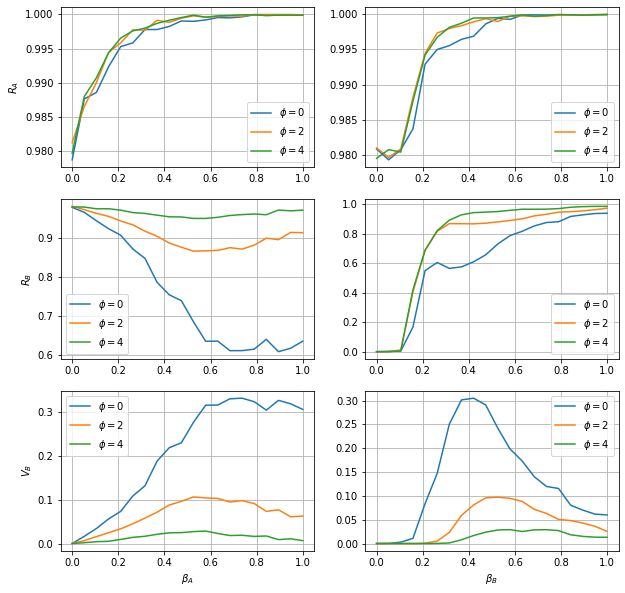

In [ ]:
rows, cols = 3, 2
fig, ax = plt.subplots(rows, cols,
                       #sharex='col', 
                       #sharey='row', 
                       figsize=(10,10))

ax[0,0].plot(df_A_phi0["betaA"], df_A_phi0["RA"], label = r"$\phi = 0$")
ax[0,0].plot(df_A_phi2["betaA"], df_A_phi2["RA"], label = r"$\phi = 2$")
ax[0,0].plot(df_A_phi4["betaA"], df_A_phi4["RA"], label = r"$\phi = 4$")

ax[1,0].plot(df_A_phi0["betaA"], df_A_phi0["RB"], label = r"$\phi = 0$")
ax[1,0].plot(df_A_phi2["betaA"], df_A_phi2["RB"], label = r"$\phi = 2$")
ax[1,0].plot(df_A_phi4["betaA"], df_A_phi4["RB"], label = r"$\phi = 4$")

ax[2,0].plot(df_A_phi0["betaA"], df_A_phi0["VB"], label = r"$\phi = 0$")
ax[2,0].plot(df_A_phi2["betaA"], df_A_phi2["VB"], label = r"$\phi = 2$")
ax[2,0].plot(df_A_phi4["betaA"], df_A_phi4["VB"], label = r"$\phi = 4$")

ax[0,1].plot(df_B_phi0["betaB"], df_B_phi0["RA"], label = r"$\phi = 0$")
ax[0,1].plot(df_B_phi2["betaB"], df_B_phi2["RA"], label = r"$\phi = 2$")
ax[0,1].plot(df_B_phi4["betaB"], df_B_phi4["RA"], label = r"$\phi = 4$")

ax[1,1].plot(df_B_phi0["betaB"], df_B_phi0["RB"], label = r"$\phi = 0$")
ax[1,1].plot(df_B_phi2["betaB"], df_B_phi2["RB"], label = r"$\phi = 2$")
ax[1,1].plot(df_B_phi4["betaB"], df_B_phi4["RB"], label = r"$\phi = 4$")

ax[2,1].plot(df_B_phi0["betaB"], df_B_phi0["VB"], label = r"$\phi = 0$")
ax[2,1].plot(df_B_phi2["betaB"], df_B_phi2["VB"], label = r"$\phi = 2$")
ax[2,1].plot(df_B_phi4["betaB"], df_B_phi4["VB"], label = r"$\phi = 4$")

#ax[0,0].set_ylim(0,1)
#ax[1,0].set_ylim(0,1)
#ax[2,0].set_ylim(0,1)

ax[0,0].grid()
ax[1,0].grid() 
ax[2,0].grid()
ax[0,1].grid()
ax[1,1].grid() 
ax[2,1].grid()

ax[0,0].legend()
ax[1,0].legend()
ax[2,0].legend()
ax[0,1].legend()
ax[1,1].legend()
ax[2,1].legend()

ax[2,0].set_xlabel(r"$\beta_A$")
ax[2,1].set_xlabel(r"$\beta_B$")

ax[0,0].set_ylabel(r"$R_A$")
ax[1,0].set_ylabel(r"$R_B$")
ax[2,0].set_ylabel(r"$V_B$")

plt.show()

### Figura 4

In [ ]:
# b2 - Var Info
grid_search("results_betaA_b2.csv", niter, GA, GB, betaA, gammaA, [0.2]*len(betaA), gammaB, 2, p, t_max)

In [ ]:
# b2 - Var Disease
grid_search("results_betaB_b2.csv", niter, GA, GB, [0.2]*len(betaB), gammaA, betaB, gammaB, 2, p, t_max)

In [ ]:
# b5 - Var Info
grid_search("results_betaA_b5.csv", niter, GA, GB, betaA, gammaA, [0.5]*len(betaA), gammaB, 2, p, t_max)

In [ ]:
# b5 - Var Desease
grid_search("results_betaB_b5.csv", niter, GA, GB, [0.5]*len(betaB), gammaA, betaB, gammaB, 2, p, t_max)

In [ ]:
# b8 - Var Info
grid_search("results_betaA_b8.csv", niter, GA, GB, betaA, gammaA, [0.8]*len(betaA), gammaB, 2, p, t_max)

In [ ]:
# b8 - Var Desease
grid_search("results_betaB_b8.csv", niter, GA, GB, [0.8]*len(betaB), gammaA, betaB, gammaB, 2, p, t_max)

In [ ]:
df_A_b2 = pd.read_csv("results_betaA_b2.csv", header = None)
df_B_b2 = pd.read_csv("results_betaB_b2.csv", header = None)
df_A_b5 = pd.read_csv("results_betaA_b5.csv", header = None)
df_B_b5 = pd.read_csv("results_betaB_b5.csv", header = None)
df_A_b8 = pd.read_csv("results_betaA_b8.csv", header = None)
df_B_b8 = pd.read_csv("results_betaB_b8.csv", header = None)

df_A_b2.columns = ["betaA", "betaB", "RA", "RB", "VB"] 
df_B_b2.columns = ["betaA", "betaB", "RA", "RB", "VB"] 
df_A_b5.columns = ["betaA", "betaB", "RA", "RB", "VB"] 
df_B_b5.columns = ["betaA", "betaB", "RA", "RB", "VB"] 
df_A_b8.columns = ["betaA", "betaB", "RA", "RB", "VB"] 
df_B_b8.columns = ["betaA", "betaB", "RA", "RB", "VB"] 

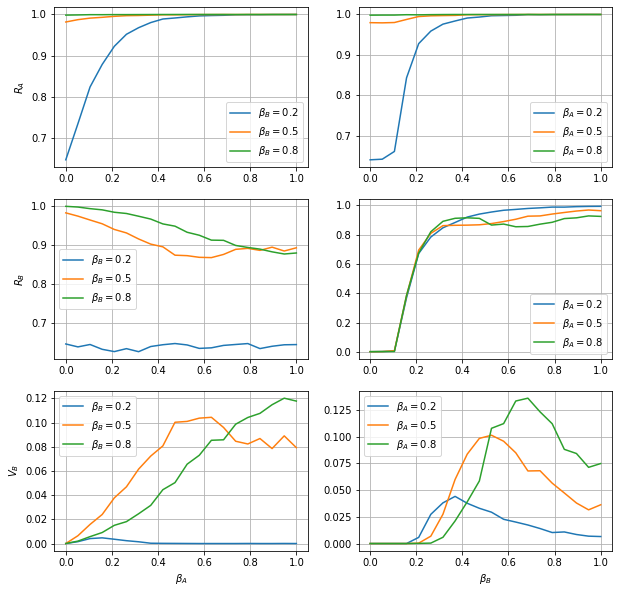

In [ ]:
rows, cols = 3, 2
fig, ax = plt.subplots(rows, cols,
                       #sharex='col', 
                       #sharey='row', 
                       figsize=(10,10))

ax[0,0].plot(df_A_b2["betaA"], df_A_b2["RA"], label = r"$\beta_B = 0.2$")
ax[0,0].plot(df_A_b5["betaA"], df_A_b5["RA"], label = r"$\beta_B = 0.5$")
ax[0,0].plot(df_A_b8["betaA"], df_A_b8["RA"], label = r"$\beta_B = 0.8$")

ax[1,0].plot(df_A_b2["betaA"], df_A_b2["RB"], label = r"$\beta_B = 0.2$")
ax[1,0].plot(df_A_b5["betaA"], df_A_b5["RB"], label = r"$\beta_B = 0.5$")
ax[1,0].plot(df_A_b8["betaA"], df_A_b8["RB"], label = r"$\beta_B = 0.8$")

ax[2,0].plot(df_A_b2["betaA"], df_A_b2["VB"], label = r"$\beta_B = 0.2$")
ax[2,0].plot(df_A_b5["betaA"], df_A_b5["VB"], label = r"$\beta_B = 0.5$")
ax[2,0].plot(df_A_b8["betaA"], df_A_b8["VB"], label = r"$\beta_B = 0.8$")

ax[0,1].plot(df_B_b2["betaB"], df_B_b2["RA"], label = r"$\beta_A = 0.2$")
ax[0,1].plot(df_B_b5["betaB"], df_B_b5["RA"], label = r"$\beta_A = 0.5$")
ax[0,1].plot(df_B_b8["betaB"], df_B_b8["RA"], label = r"$\beta_A = 0.8$")

ax[1,1].plot(df_B_b2["betaB"], df_B_b2["RB"], label = r"$\beta_A = 0.2$")
ax[1,1].plot(df_B_b5["betaB"], df_B_b5["RB"], label = r"$\beta_A = 0.5$")
ax[1,1].plot(df_B_b8["betaB"], df_B_b8["RB"], label = r"$\beta_A = 0.8$")

ax[2,1].plot(df_B_b2["betaB"], df_B_b2["VB"], label = r"$\beta_A = 0.2$")
ax[2,1].plot(df_B_b5["betaB"], df_B_b5["VB"], label = r"$\beta_A = 0.5$")
ax[2,1].plot(df_B_b8["betaB"], df_B_b8["VB"], label = r"$\beta_A = 0.8$")

#ax[0,0].set_ylim(0,1)
#ax[1,0].set_ylim(0,1)
#ax[2,0].set_ylim(0,1)

ax[0,0].grid()
ax[1,0].grid() 
ax[2,0].grid()
ax[0,1].grid()
ax[1,1].grid() 
ax[2,1].grid()

ax[0,0].legend()
ax[1,0].legend()
ax[2,0].legend()
ax[0,1].legend()
ax[1,1].legend()
ax[2,1].legend()

ax[2,0].set_xlabel(r"$\beta_A$")
ax[2,1].set_xlabel(r"$\beta_B$")

ax[0,0].set_ylabel(r"$R_A$")
ax[1,0].set_ylabel(r"$R_B$")
ax[2,0].set_ylabel(r"$V_B$")

plt.show()

## Figura 6

In [ ]:
def SIR(old_stateA, old_stateAA, old_stateB, GA, betaA, gammaA):
    
    new_stateA = old_stateA.copy()
    new_stateAA = old_stateAA.copy()
    
    # Infection phase                
    for node in range(len(old_stateA)):
                    
        if old_stateA[node] == 'IA':
        
            l = GA.neighbors(node)

            for i in l:                
                if old_stateA[i] == 'SA':                    
                    x = random.random()                    
                    if x < betaA:
                        new_stateA[i] = 'IA'
                        new_stateAA[i] = 'IAA'
    
    # Recovery phase                
    for node in range(len(old_stateA)):
        
        if old_stateA[node] == 'IA':
            x = random.random()
            if x < gammaA:
                new_stateA[node] = 'RA'
                new_stateAA[node] = 'RA'
                
     # Information phase                
    for node in range(len(old_stateA)):
        if (old_stateA[node] == 'SA' and old_stateB[node] == 'IB'):
            new_stateA[node] = 'IA'
            new_stateAA[node] = 'IAB'
            
    return new_stateA, new_stateAA

In [ ]:
def propagator(which_out, GA, GB, betaA, gammaA, betaB, gammaB, phi, p, t_max):

    dt = 0
    
    NB = GB.number_of_nodes()
    NA = GA.number_of_nodes()
    node_labelsB = GB.nodes()
    node_labelsA = GA.nodes()
    
    old_stateA = ['SA' for i in node_labelsA]
    old_stateB = ['SB' for i in node_labelsB]
   
    for i in range(10):
        seed = random.choice(range(NB))
        old_stateA[seed] = 'IA' 
        old_stateB[seed] = 'IB' 
    
    if which_out == "c":
        SA_frac = []
        IA_frac = []
        RA_frac = []
        SB_frac = []
        IB_frac = []
        RB_frac = []
        VB_frac = []
    
    rhoAA = []
    rhoAB = []
    
    old_stateAA = old_stateA.copy()
    
    while dt < t_max:

        #print(dt, old_stateA.count('SA'), old_stateA.count('IA'), old_stateA.count('RA'))
        #print(dt, old_stateB.count('SB'), old_stateB.count('IB'), old_stateB.count('RB'), old_stateB.count('VB'))
        
        new_stateA, new_stateAA = SIR(old_stateA, old_stateAA, old_stateB, GA, betaA, gammaA) 
        new_stateB = SIRV(old_stateA, old_stateB, GB, betaB, gammaB, phi, p)
        
        old_stateA = new_stateA.copy()
        old_stateAA = new_stateAA.copy()
        old_stateB = new_stateB.copy()

        if which_out == "c":
            SA_frac.append(new_stateA.count('SA')/NA)
            IA_frac.append(new_stateA.count('IA')/NA)
            RA_frac.append(new_stateA.count('RA')/NA)
            SB_frac.append(new_stateB.count('SB')/NB)
            IB_frac.append(new_stateB.count('IB')/NB)
            RB_frac.append(new_stateB.count('RB')/NB)
            VB_frac.append(new_stateB.count('VB')/NB)
            rhoAA.append(new_stateAA.count('IAA')/NA)
            rhoAB.append(new_stateAA.count('IAB')/NA)

        elif which_out == "f":
            SA_frac = new_stateA.count('SA')/NA
            IA_frac = new_stateA.count('IA')/NA
            RA_frac = new_stateA.count('RA')/NA
            SB_frac = new_stateB.count('SB')/NB
            IB_frac = new_stateB.count('IB')/NB
            RB_frac = new_stateB.count('RB')/NB
            VB_frac = new_stateB.count('VB')/NB

        else:
            print("Not valid option!")
        
        dt += 1
        
    return (IB_frac, rhoAA, rhoAB)

In [ ]:
res5 = propagator("c", GA, GB, 0.13, gammaA, 0.3, gammaB, 2, p, t_max)
res7 = propagator("c", GA, GB, 0.22, gammaA, 0.3, gammaB, 2, p, t_max)
res9 = propagator("c", GA, GB, 0.4, gammaA, 0.3, gammaB, 2, p, t_max)

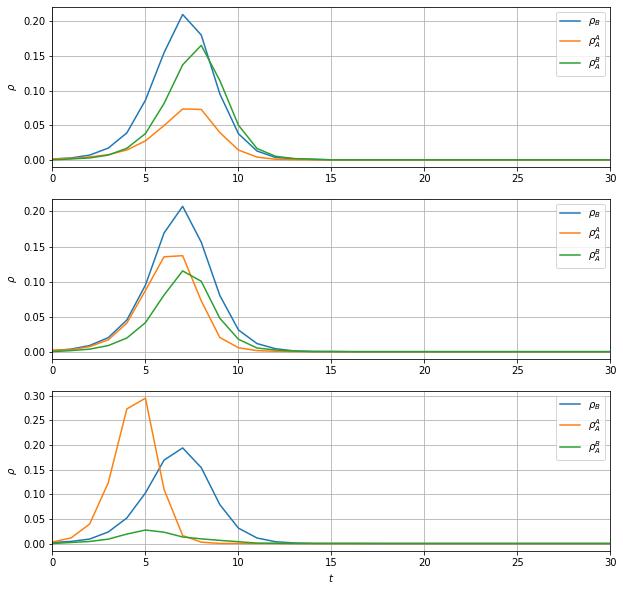

In [ ]:
rows, cols = 3, 1
fig, ax = plt.subplots(rows, cols,
                       #sharex='col', 
                       #sharey='row', 
                       figsize=(10,10))

t = [i for i in range(len(res5[0]))]

ax[0].plot(t, res5[0], label = r"$\rho_{B}$")
ax[0].plot(t, res5[1], label = r"$\rho_{A}^{A}$")
ax[0].plot(t, res5[2], label = r"$\rho_{A}^{B}$")

ax[1].plot(t, res7[0], label = r"$\rho_{B}$")
ax[1].plot(t, res7[1], label = r"$\rho_{A}^{A}$")
ax[1].plot(t, res7[2], label = r"$\rho_{A}^{B}$")

ax[2].plot(t, res9[0], label = r"$\rho_{B}$")
ax[2].plot(t, res9[1], label = r"$\rho_{A}^{A}$")
ax[2].plot(t, res9[2], label = r"$\rho_{A}^{B}$")

ax[0].set_xlim(0,30)
ax[1].set_xlim(0,30)
ax[2].set_xlim(0,30)

ax[0].grid()
ax[1].grid() 
ax[2].grid()

ax[0].legend()
ax[1].legend()
ax[2].legend()

ax[2].set_xlabel(r"$t$")

ax[0].set_ylabel(r"$\rho$")
ax[1].set_ylabel(r"$\rho$")
ax[2].set_ylabel(r"$\rho$")

plt.show()

### Plot

In [ ]:
plot_beta(df_A["betaA"], df_B["betaB"], df_A["RA"], df_A["RB"], df_A["VB"], df_B["RA"], df_B["RB"], df_B["VB"])

### Full Evolution

In [ ]:
df_A = pd.read_csv("results_betaA.csv", header=None)
df_A.columns = ["betaA", "betaB", "RA", "RB", "VB"] 

In [ ]:
# Now run the complete model for best value betaA = 0.3

res = propagator("c", GA, GB, betaA[df_A["VB"].idxmax()], gammaA, betaB[4], gammaB, phi, p, t_max)

In [ ]:
plot_data(res)